# Predicting Customer Churn

by Jared Godar 2021-11-29

---

## Project Goal

This project aims to use historical customer data to build a classification model to predict what customers are likely to churn to identify drivers of churn to devise better customer retention strategies.

## Project Description

Acquiring new customers is expensive. Between marketing costs and initial offers and promotions, a significant investment is made in bringing a customer to Telco, Inc. We are losing too many customers to our competitors and having to find new customers to replace them. Here we will analyze the attributes of customers who leave and stay, develop a model to predict churn based on those attributes, make recommendations to increase customer retention, and provide a list of current customers and their predicted likelihood to churn.

## Initial Questions

What factors increase churn?

What factors increase retention?

Are there factors that don't matter?

Are there any demographic categories (age, sex, etc.) more or less likely to churn?

Does the type of service or services the customer subscribes to influence churn?



---

## Data Dictionary

|Target|Datatype|Definition|
|:-------|:--------|:----------|
| churn_encoded | int64 | 0: Customer retained 1: Customer Churned|


</br>
</br>

</br>


|Feature|Datatype|Definition|
|:-------|:--------|:----------|
| senior_citizen       | int64 |    0: Not Senior 1: Senior |
| monthly_charges        | float64 |    month;y charges in dollars |
| tenure       |  int64 |    tenure in months |
| paperless_billing_encoded        | int64 |    i0: no paperless billing 1:paperless billing |
| internet_service_type_Fiber optic        | uint8 |    0: No fiber 1: fiber |
| payment_type_Electronic check        | uint8 |    0: no e-check 1:e-check |

---

## Import Libraries

Here we import the various functions, modules, and libraries necessary.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

# import our own acquire module
import telcoacquire

# Remove limits on viewing dataframes
pd.set_option('display.max_columns', None)

---

## Wrangle Telco Dat

To acquire the titanic data, I used the `telco_churn` datbase on the Codeup server, selecting all columns from the `customers` table and joining the `contract_type_id`, `internet_service_types`, and `payment_type_id` tables with the following query:

    select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)

In [2]:
# Acquire data from the sql database telco_churn

telco_df = telcoacquire.new_telco_data()

---

## Data Cleaning

To clean the data, I did the following:

1. Dropped Columns
    - *Duplicates:* Since `payment_type_id` duplicates `payment_type`, `internet_service_type_id` duplicates `internet_service_type`, and `contract_type_id` duplicates `contract_type`, we only need one column of each pair. Drop the `_id` columns
2. Dropped Rows
    - There were 11 new customers with null values for total charges
    - Since these customers have not had an opportunity to churn, they offer no predictive value and were fropped from the dataset
3. Changed the `total_charges` column data type from `object` to `float`.
4. Created Dummy Variables for object data types
    - Columns with two options were assigned a new encoded column with the values `0` or `1` (`gender`, `partner`, `dependents`, `phonse_service`, `paperless_billing`, `churn`)
    - Columns with more than two options were one-hot encoded (`multiple_lines`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `contract_type`, `internet_service_type`, `payment_type`)
5. Encoding created some redundant columns `no_phone` `no_internet`. Since this information was captured elsewhere, these columns were also dropped.

In [3]:
import telco_prepare

telco_df=telco_prepare.prep_telco(telco_df)

---

## Split the data

Data will be split into a training, validation, and test data set:
    - *Train* Perform exploratory analysis and construct models
    - *Validate* verify models are not overfit to training data
    - *Test* used only once with the best model to approximate how the model will perform on new data

In [4]:
telco_train, telco_validate, telco_test=telco_prepare.split_telco(telco_df)

---

## Data Dictionary

|Target|Datatype|Definition|
|:-------|:--------|:----------|
| churn_encoded | int64 | 0: Customer retained 1: Customer Churned|


</br>
</br>

</br>


|Feature|Datatype|Definition|
|:-------|:--------|:----------|
| senior_citizen       | int64 |    0: Not Senior 1: Senior |
| monthly_charges        | float64 |    month;y charges in dollars |
| tenure       | 150 non-null: int64 |    tenure in months |
| paperless_billing_encoded        | int64 |    i0: no paperless billing 1:paperless billing |
| internet_service_type_Fiber optic        | uint8 |    0: No fiber 1: fiber |
| payment_type_Electronic check        | uint8 |    0: no e-check 1:e-check |

---

## Exploratory Analysis

### Question 1: What factors increase churn?

In [6]:
# Configure plots

import seaborn as sns


plt.rc('font', size=14)
plt.rc('figure', figsize=(14, 10))

In [10]:
# Import stats and set confindence interval

import scipy.stats as stats

conf_interval = 0.95
alpha = 1 - conf_interval

In [8]:
# Create dataframes of customers who churned and did not churn

churn = telco_train[telco_train['churn_encoded'] == 1]
no_churn = telco_train[telco_train['churn_encoded'] == 0]

Text(0.5, 0, 'Churned')

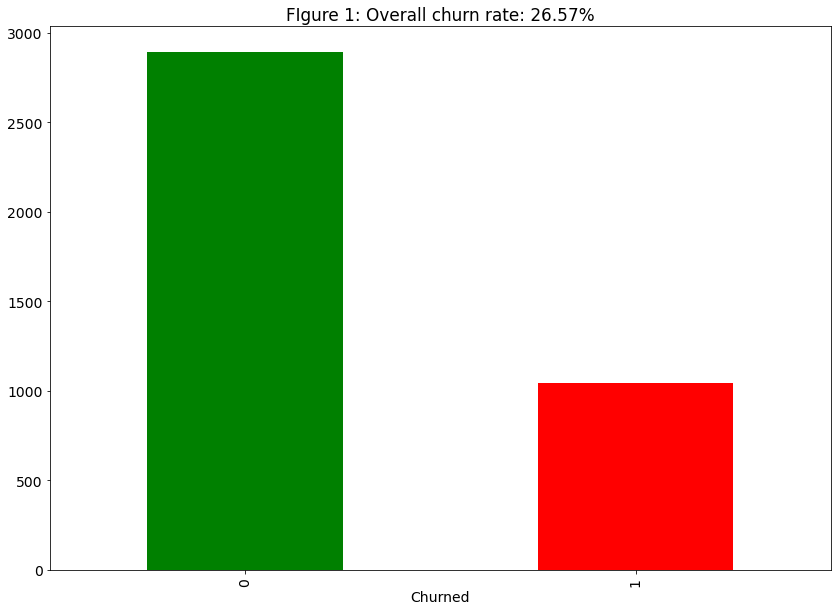

In [129]:
# Plot overall churn rate

colors=['green', 'red']
telco_train.churn_encoded.value_counts().sort_index().plot.bar(color=['green', 'red'])
churn_rate = telco_train.churn_encoded.mean()
plt.title(f"FIgure 1: Overall churn rate: {churn_rate:.2%}")
plt.xlabel('Churned')

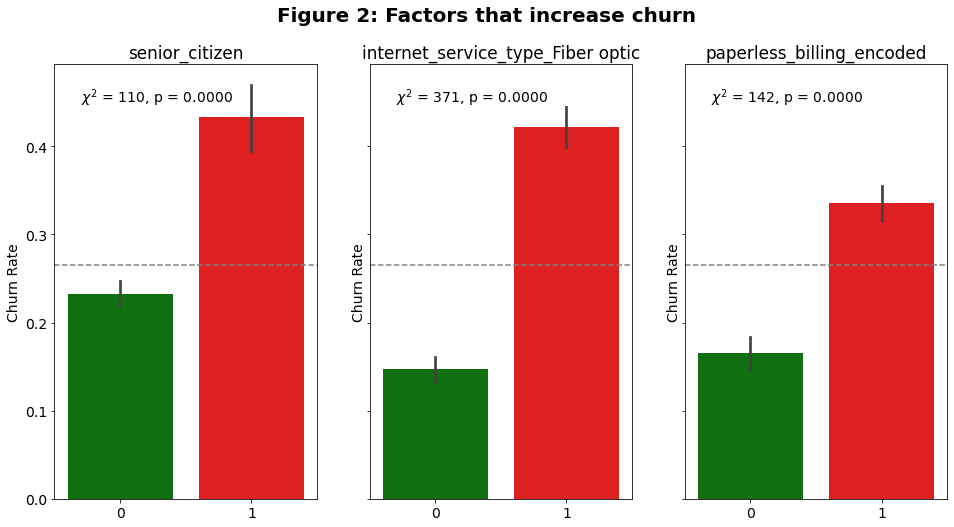

In [140]:
features = ['senior_citizen', 'internet_service_type_Fiber optic',  'paperless_billing_encoded']

colors =['green','red']
chi2 = [110, 371, 142]



fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), sharey=True)
fig.suptitle('Figure 2: Factors that increase churn', fontsize=20, fontweight='bold') 
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=telco_train, ax=ax[i], palette=colors)
    ax[i].text(x = -.3, y=.45, s=f'$\chi^2$ = {chi2[i]}, p = 0.0000')

    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')


### Question 2: What features increase retention?

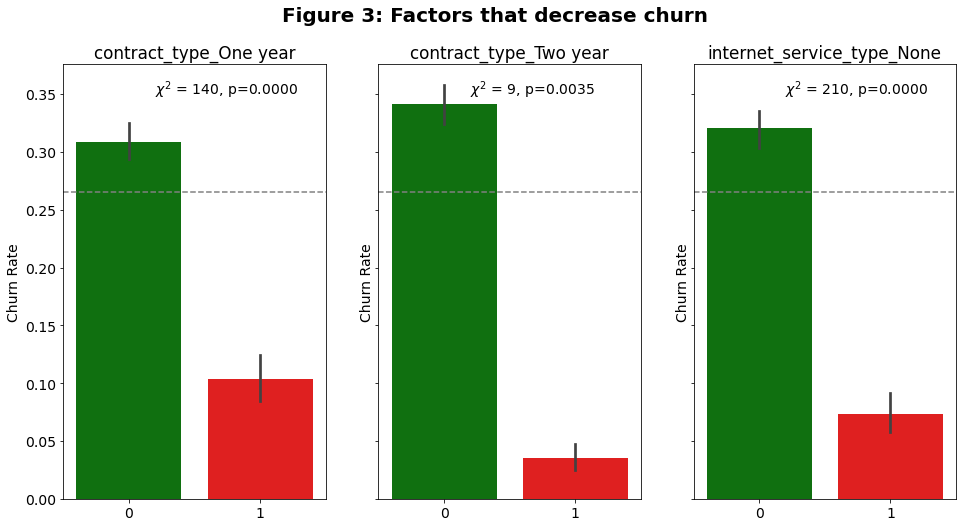

In [139]:
features = ['contract_type_One year', 'contract_type_Two year', 'internet_service_type_None']

colors =['green', 'red']
chi2b = [140, 9, 210]
pb = [0.0000, 0.0035, 0.0000]


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), sharey=True)
fig.suptitle('Figure 3: Factors that decrease churn', fontsize=20, fontweight='bold') 
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=telco_train, ax=ax[i], palette=colors)
    ax[i].text(x = 0.2, y=.35, s=f'$\chi^2$ = {chi2b[i]}, p={pb[i]:.4f}')

    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')



### Question 3: What features don't influence churn

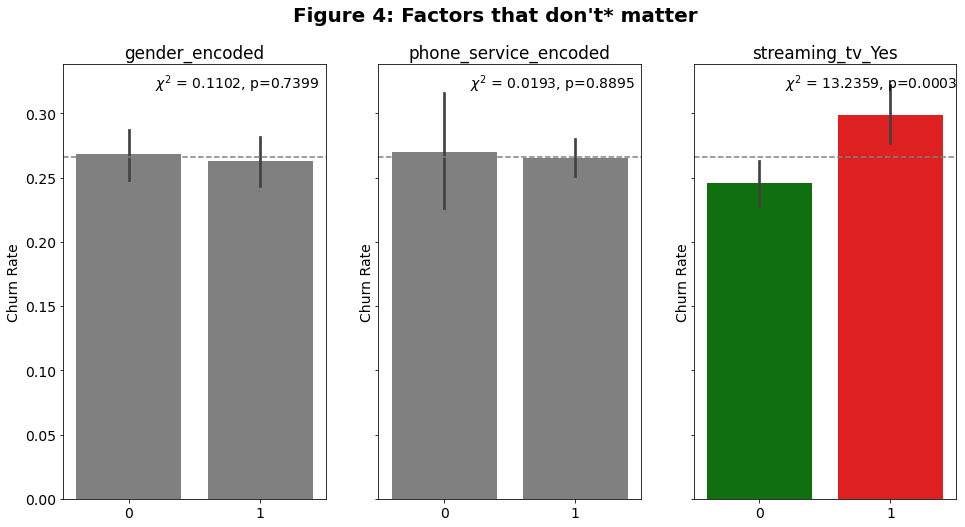

In [142]:
features = ['gender_encoded','phone_service_encoded', 'streaming_tv_Yes']

colors =['gray', 'gray']
colors2=['red', 'green']
chi2c = [.1102, .0193, 13.2359]
pc = [0.7399, 0.8895, 0.0003]



fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), sharey=True)
fig.suptitle("Figure 4: Factors that don't* matter", fontsize=20, fontweight='bold') 
for i, feature in enumerate(features):
    if i == 2:
        colors=['green', 'red']
    sns.barplot(feature, 'churn_encoded', data=telco_train, ax=ax[i], palette=colors)
    ax[i].text(x = 0.2, y=.32, s=f'$\chi^2$ = {chi2c[i]}, p={pc[i]:.4f}')

    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')
    

## Question 4: Is there a corrolation between monthly charges and churn rate?

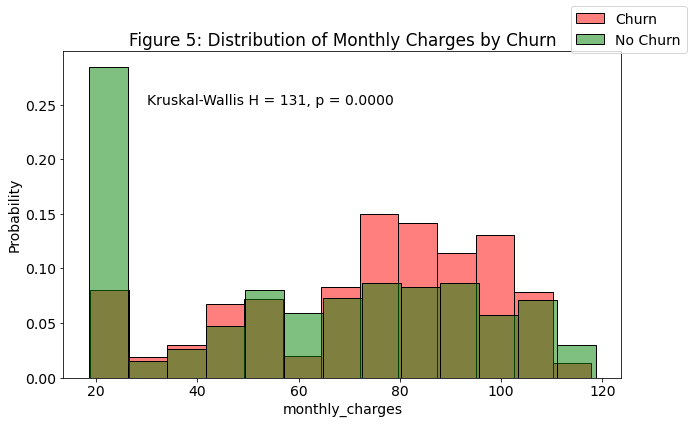

In [148]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np


fig = plt.figure(figsize=(10,6))
plt.title('Figure 5: Distribution of Monthly Charges by Churn')
sns.histplot(data=churn['monthly_charges'], stat='probability', color = 'red', alpha=0.5, label='Churn')
sns.histplot(data=no_churn['monthly_charges'], stat='probability', color='green', alpha=0.5, label='No Churn')
fig.legend(labels=['Churn','No Churn'])
plt.text(x = 30, y=.25, s=f'Kruskal-Wallis H = 131, p = 0.0000')
plt.show;

In [145]:
import scipy

scipy.stats.kruskal(churn.monthly_charges, no_churn.monthly_charges)

KruskalResult(statistic=130.80822711455886, pvalue=2.7272064616213124e-30)

---

## Statistical Tests

### Do seniors churn at a different rate?

$H_0$: Churn independent of senior status

$H_1$: Churn dependent on senior status

Create Observation Table

Use $\Chi^2$ to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

In [14]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['Senior=1', 'Senior=0']

senior_observed = pd.DataFrame([[churn.senior_citizen.value_counts()[1], churn.senior_citizen.value_counts()[0]], [no_churn.senior_citizen.value_counts()[1], no_churn.senior_citizen.value_counts()[0]]], index=index, columns=columns)
senior_observed


,Senior=1,Senior=0
Churn,280,766
No Churn,367,2524


In [15]:
senior_chi2, senior_p, senior_degf, senior_expected = stats.chi2_contingency(senior_observed)

print('Observed\n')
print(senior_observed.values)
print('---\nExpected\n')
print(senior_expected)
print('---\n')
print(f'chi^2 = {senior_chi2:.4f}')
print(f'p     = {senior_p:.4f}')
if senior_p < alpha:
      print('We can reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

Observed

[[ 280  766]
 [ 367 2524]]
---
Expected

[[ 171.8978918  874.1021082]
 [ 475.1021082 2415.8978918]]
---

chi^2 = 109.7635
p     = 0.0000
We can reject the null hypothesis


### Are churn and fiber optic independent?

$H_0$: Churn and fiber optic internet are independent

$H_1$: Churn and Fiber are dependent

Create Observation Table

Use $\Chi^2$ to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

In [16]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['Fiber=1', 'Fiber=0']

fiber_observed = pd.DataFrame([[716, 330], [982, 1901]], index=index, columns=columns)
fiber_observed

,Fiber=1,Fiber=0
Churn,716,330
No Churn,982,1901


In [17]:
# Make observation table

index = ['Churn', 'No Churn']
columns = ['Fiber=1', 'Fiber=0']

fiber_observed = pd.DataFrame([[churn['internet_service_type_Fiber optic'].value_counts()[1], churn['internet_service_type_Fiber optic'].value_counts()[0]], [no_churn['internet_service_type_Fiber optic'].value_counts()[1], no_churn['internet_service_type_Fiber optic'].value_counts()[0]]], index=index, columns=columns)
fiber_observed

,Fiber=1,Fiber=0
Churn,716,330
No Churn,982,1909


In [18]:
fiber_chi2, fiber_p, fiber_degf, fiber_expected = stats.chi2_contingency(fiber_observed)

print('Observed\n')
print(fiber_observed.values)
print('---\nExpected\n')
print(fiber_expected)
print('---\n')
print(f'chi^2 = {fiber_chi2:.4f}')
print(f'p     = {fiber_p:.4f}')
if fiber_p < alpha:
      print('We can reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

Observed

[[ 716  330]
 [ 982 1909]]
---
Expected

[[ 451.13233426  594.86766574]
 [1246.86766574 1644.13233426]]
---

chi^2 = 370.9722
p     = 0.0000
We can reject the null hypothesis


Chi-squared tests for all of the plots above were conducted confirming the visual hypotheses of factors that increased churn, reduced churn, and did not matter.

---

## Predicting Churn

In [22]:
# Import libraries for modeling

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score


In [25]:
features = ['senior_citizen', 'monthly_charges', 'tenure', 'paperless_billing_encoded', 'internet_service_type_Fiber optic', 'payment_type_Electronic check']
target = ['churn_encoded']
X_train, y_train, X_validate, y_validate, X_test, y_test = feature_target_selector(features, target)

In [23]:
# Split data for modeling

def feature_target_selector(features, target, train=telco_train, validate=telco_validate, test=telco_test):
    X_train = train[features]
    y_train = train[target]
    X_validate = validate[features]
    y_validate = validate[target]
    X_test = test[features]
    y_test = test[target]
    return X_train, y_train, X_validate, y_validate, X_test, y_test

### Baseline

Most customers do not churn, so our baseline model predicts nobody will ever churn (churn=0, 100%)

In [26]:
evaluations = pd.DataFrame({"actual": y_validate.churn_encoded})
evaluations["baseline"] = 0
matrix = pd.crosstab(evaluations.actual, evaluations.baseline)
matrix

baseline,0
actual,
0,1239
1,449


In [60]:
baseline_accuracy = (1239/(1239+449))
baseline_accuracy

0.7340047393364929

---

## Model 1: Decision Tree

In [27]:
tree = DecisionTreeClassifier(random_state = 123, max_depth = 25)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_train)
y_pred_proba = tree.predict_proba(X_train)

In [28]:
confusion_matrix(y_train, y_pred)


array([[2891,    0],
       [  30, 1016]])

In [32]:
# Classify predicted values
def print_return_cm_details(y_pred, y_train=y_train):
    true_positive_count = confusion_matrix(y_train, y_pred)[1][1]
    print(f'True positives: {true_positive_count}')
    false_negative_count = confusion_matrix(y_train, y_pred)[1][0]
    print(f'False negatives: {false_negative_count}')
    false_positive_count = confusion_matrix(y_train, y_pred)[0][1]
    print(f'False positives: {false_positive_count}')
    true_negative_count = confusion_matrix(y_train, y_pred)[0][0]
    print(f'True negatives: {true_negative_count}')
    return true_positive_count, false_negative_count, false_positive_count, true_negative_count


In [33]:
tp, fn, fp, tn = print_return_cm_details(y_pred)

True positives: 1016
False negatives: 30
False positives: 0
True negatives: 2891


In [34]:
# Assess accuracy

print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2891
           1       1.00      0.97      0.99      1046

    accuracy                           0.99      3937
   macro avg       0.99      0.99      0.99      3937
weighted avg       0.99      0.99      0.99      3937



In [35]:
print('Decision Tree training set accuracy: {:.4f}'
     .format(tree.score(X_train, y_train)))

print('Decision Tree training set F1: {:.4f}'
     .format(f1_score(y_train, y_pred)))

recall_tree = tp/(tp+fn)

print('Decision Tree training set Recall: {:.4f}'
     .format(recall_tree))

Decision Tree training set accuracy: 0.9924
Decision Tree training set F1: 0.9855
Decision Tree training set Recall: 0.9713


---

## Model 2: Random Forest

In [36]:
rf = RandomForestClassifier(random_state = 123, min_samples_leaf = 1, max_depth = 20)
rf.fit(X_train, y_train)
print(rf.feature_importances_)
print(X_train.columns)

[0.02208226 0.48739102 0.35559728 0.02309609 0.06369742 0.04813593]
Index(['senior_citizen', 'monthly_charges', 'tenure',
       'paperless_billing_encoded', 'internet_service_type_Fiber optic',
       'payment_type_Electronic check'],
      dtype='object')


In [37]:
y_pred2 = rf.predict(X_train)
y_pred2_proba = rf.predict_proba(X_train)
print(confusion_matrix(y_train, y_pred2))

[[2887    4]
 [  24 1022]]


In [38]:
tp, fn, fp, tn = print_return_cm_details(y_pred2)


True positives: 1022
False negatives: 24
False positives: 4
True negatives: 2887


In [39]:
print(classification_report(y_train, y_pred2))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2891
           1       1.00      0.98      0.99      1046

    accuracy                           0.99      3937
   macro avg       0.99      0.99      0.99      3937
weighted avg       0.99      0.99      0.99      3937



In [41]:
print('Random Forest training set accuracy: {:.4f}'
     .format(rf.score(X_train, y_train)))

print('Random Forest training set F1: {:.4f}'
     .format(f1_score(y_train, y_pred2)))

recall_rf = tp/(tp+fn)

print('Random Forest training set Recall: {:.4f}'
     .format(recall_rf))

Random Forest training set accuracy: 0.9929
Random Forest training set F1: 0.9865
Random Forest training set Recall: 0.9771


---

## Model 3: KNN

In [42]:
k = math.floor(math.sqrt(X_train.shape[0]))


In [43]:
knn = KNeighborsClassifier(n_neighbors=k, weights='uniform') #n_neighbors is based on square root of number of observations
knn.fit(X_train, y_train)
y_pred3 = knn.predict(X_train)
y_pred3_proba = knn.predict_proba(X_train)

In [44]:
print(confusion_matrix(y_train, y_pred3))


[[2697  194]
 [ 610  436]]


In [45]:
tp, fn, fp, tn = print_return_cm_details(y_pred3)


True positives: 436
False negatives: 610
False positives: 194
True negatives: 2697


In [46]:
print(classification_report(y_train, y_pred3))


              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2891
           1       0.69      0.42      0.52      1046

    accuracy                           0.80      3937
   macro avg       0.75      0.67      0.70      3937
weighted avg       0.78      0.80      0.78      3937



In [47]:
print('KNN Train Accuracy: {:.4f}'
     .format(knn.score(X_train, y_train)))

print('KNN Train F1: {:.4f}'
     .format(f1_score(y_train, y_pred3)))

recall_knn = tp/(tp+fn)

print('KNN Train Recall: {:.4f}'
     .format(recall_knn))

KNN Train Accuracy: 0.7958
KNN Train F1: 0.5203
KNN Train Recall: 0.4168


---

## Model 4: Logistic Regression

In [48]:
logr = LogisticRegression(random_state=123, solver='lbfgs')
logr.fit(X_train, y_train)
print('Coefficient: \n', logr.coef_)
print('Intercept: \n', logr.intercept_)

Coefficient: 
 [[ 0.53974434  0.00978369 -0.04481712  0.49239456  0.89988463  0.53167343]]
Intercept: 
 [-1.54586777]


In [49]:
y_pred4 = logr.predict(X_train)
y_pred4_proba = logr.predict_proba(X_train)

In [50]:
confusion_matrix(y_train, y_pred4)


array([[2640,  251],
       [ 563,  483]])

In [51]:
print(classification_report(y_train, y_pred4))


              precision    recall  f1-score   support

           0       0.82      0.91      0.87      2891
           1       0.66      0.46      0.54      1046

    accuracy                           0.79      3937
   macro avg       0.74      0.69      0.70      3937
weighted avg       0.78      0.79      0.78      3937



In [52]:
print('Logistic Regression training Accuracy: {:.4f}'
     .format(logr.score(X_train, y_train)))

print('Logistic Regression Training F1: {:.4f}'
     .format(f1_score(y_train, y_pred4)))

recall_logr = tp/(tp+fn)

print('Logistic Regression training Recall: {:.4f}'
     .format(recall_logr))

Logistic Regression training Accuracy: 0.7932
Logistic Regression Training F1: 0.5427
Logistic Regression training Recall: 0.4168


---

## Validate

In [53]:
print("Model 1: Decision Tree")

print('Accuracy: {:.4f}'.format(tree.score(X_validate, y_validate)))

y_pred_val = tree.predict(X_validate)

print(confusion_matrix(y_validate, y_pred_val))

print(classification_report(y_validate, y_pred_val))

Model 1: Decision Tree
Accuracy: 0.7216
[[1003  236]
 [ 234  215]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1239
           1       0.48      0.48      0.48       449

    accuracy                           0.72      1688
   macro avg       0.64      0.64      0.64      1688
weighted avg       0.72      0.72      0.72      1688



In [54]:
print("Model 2: Random Forest")

print('Accuracy: {:.4f}'.format(rf.score(X_validate, y_validate)))

y_pred_rf = rf.predict(X_validate)

print(confusion_matrix(y_validate, y_pred_rf))

print(classification_report(y_validate, y_pred_rf))

Model 2: Random Forest
Accuracy: 0.7713
[[1079  160]
 [ 226  223]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1239
           1       0.58      0.50      0.54       449

    accuracy                           0.77      1688
   macro avg       0.70      0.68      0.69      1688
weighted avg       0.76      0.77      0.77      1688



In [55]:
print("Model 3: K-Nearest Neighbors")

print('Accuracy: {:.4f}'.format(knn.score(X_validate, y_validate)))

y_pred_knn = knn.predict(X_validate)

print(confusion_matrix(y_validate, y_pred_knn))

print(classification_report(y_validate, y_pred_knn))

Model 3: K-Nearest Neighbors
Accuracy: 0.7909
[[1142   97]
 [ 256  193]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1239
           1       0.67      0.43      0.52       449

    accuracy                           0.79      1688
   macro avg       0.74      0.68      0.69      1688
weighted avg       0.78      0.79      0.77      1688



In [56]:
print("Model 4: Logistic Regression")

print('Accuracy: {:.4f}'.format(logr.score(X_validate, y_validate)))

y_pred_lr = logr.predict(X_validate)

print(confusion_matrix(y_validate, y_pred_lr))

print(classification_report(y_validate, y_pred_lr))

Model 4: Logistic Regression
Accuracy: 0.7927
[[1117  122]
 [ 228  221]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1239
           1       0.64      0.49      0.56       449

    accuracy                           0.79      1688
   macro avg       0.74      0.70      0.71      1688
weighted avg       0.78      0.79      0.78      1688



---

## Test

Our logistic regression model performed best so we will test it on unseen data

In [58]:
print("Test Performance: [Logistic Regression")

print('Accuracy: {:.4f}'.format(logr.score(X_test, y_test)))

y_pred_test = logr.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

Test Performance: [Logistic Regression
Accuracy: 0.8003
[[940  93]
 [188 186]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.67      0.50      0.57       374

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407



---

## Conclusion

### Summary

- The models were effective increasing churn prediction accuracy to 83% from a baseline of 73%.
- Senior citizen, fiber opric internet, and paperless billing were strong predictors of churn
- One year contracts, two year contracts, and not having internet were strong predictors for retention
- Gender and phone service didn't matter and streaming tv doesn't matter much

### Recommendations
- Offer a senior discount to reduce churn in this population
- Determine why fiber optic customers churn so much?
    - Cost too high?
    - Problem with fiber service?
    - Address underlying issues to reduce churn in this population (reduce cost of service or improve service as appropriate)

### Next Steps
- Use GridsearchCV and RandomSearchCV to test different hyperparameters for each model to see if it can improve accuracy.
- Since our original training data was unbalanced, synthetic minority over-sampling (SMOTE) may be useful
- Consider feature enginineering of combining columns and see if it increases accuracy.
- Experiment with different predictor columns to see if accuracy can be improved.
- Consider additional model types or algorithms.